In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

sys.path.append("../")
from models.backbone.darknet53 import DarkNet53

In [2]:
import matplotlib.pyplot as plt

In [23]:
BATCH_SIZE = 3
NUM_CLASSES = 102

In [27]:
# dataset

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(
    1.0 / 255
)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/knapanda/local/casual/data/101_ObjectCategories/",
    # "C:\\Users\karan\\tensorflow_datasets\\downloads\\101_ObjectCategories\\",
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=BATCH_SIZE,
)
train_ds_norm = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds_norm = train_ds
train_ds_norm.cache()
train_ds_norm.shuffle(buffer_size=1000)
train_ds_norm.batch(10)
train_ds_norm.prefetch(tf.data.experimental.AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/knapanda/local/casual/data/101_ObjectCategories/",
    # "C:\\Users\karan\\tensorflow_datasets\\downloads\\101_ObjectCategories\\",
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=BATCH_SIZE,
)
val_ds_norm = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_norm = val_ds
val_ds_norm.cache()
val_ds_norm.shuffle(buffer_size=1000)
val_ds_norm.batch(10)
val_ds_norm.prefetch(tf.data.experimental.AUTOTUNE)

Found 9144 files belonging to 102 classes.
Using 7316 files for training.
Found 9144 files belonging to 102 classes.
Using 1828 files for validation.


<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [29]:
image, label = None, None
for x, y in train_ds_norm:
    image, label = x, y
    break

In [24]:
def build_classification_model():
    darknet_backbone = DarkNet53(NUM_CLASSES)
    darknet_backbone.build_graph(
        (
            BATCH_SIZE,
            128,
            128,
            3,
        )
    )

    print(darknet_backbone.summary())
    sample_image = np.asfarray(np.random.randint(0, 255, (10, 256, 256, 3), np.uint8))
    print("Printing forward pass time")
    start_time = time.time()
    sample_output = darknet_backbone(sample_image)
    print("sample output {}".format(sample_output))
    end_time = time.time()
    print("Time taken to conduct inference: {}".format(end_time - start_time))
    return darknet_backbone

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

In [30]:
model = build_classification_model()



predictions = model(x, training=True)
loss = loss_object(y, predictions)

Model: "dark_net53_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
block1_conv_1 (Conv2D)       (None, 32, 32, 32)        2080      
_________________________________________________________________
block1_conv_1_leaky (LeakyRe (None, 32, 32, 32)        0         
_________________________________________________________________
block1_conv_2 (Conv2D)       (None, 32, 32, 64)        18496     
_________________________________________________________________
block1_conv_2_leaky (LeakyRe (None, 32, 32, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)      

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

### Creating mini-dataset for yolov3

In [6]:
import os
import sys
import json

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [15]:
import PIL
from PIL import Image

In [2]:
labelled_data = {}

In [33]:
image_path = "/home/knapanda/local/casual/yolov3-tf2/models/data/sample/dog.jpg"
label_patg = "/home/knapanda/local/casual/yolov3-tf2/models/data/sample/labels.json"

In [7]:
image = Image.open(image_path)

In [19]:
image = image.resize((640, 640), resample=PIL.Image.LANCZOS, reducing_gap=3)

In [20]:
image_np = np.asarray(image, dtype=np.uint8)

In [23]:
image_np.shape

(640, 640, 3)

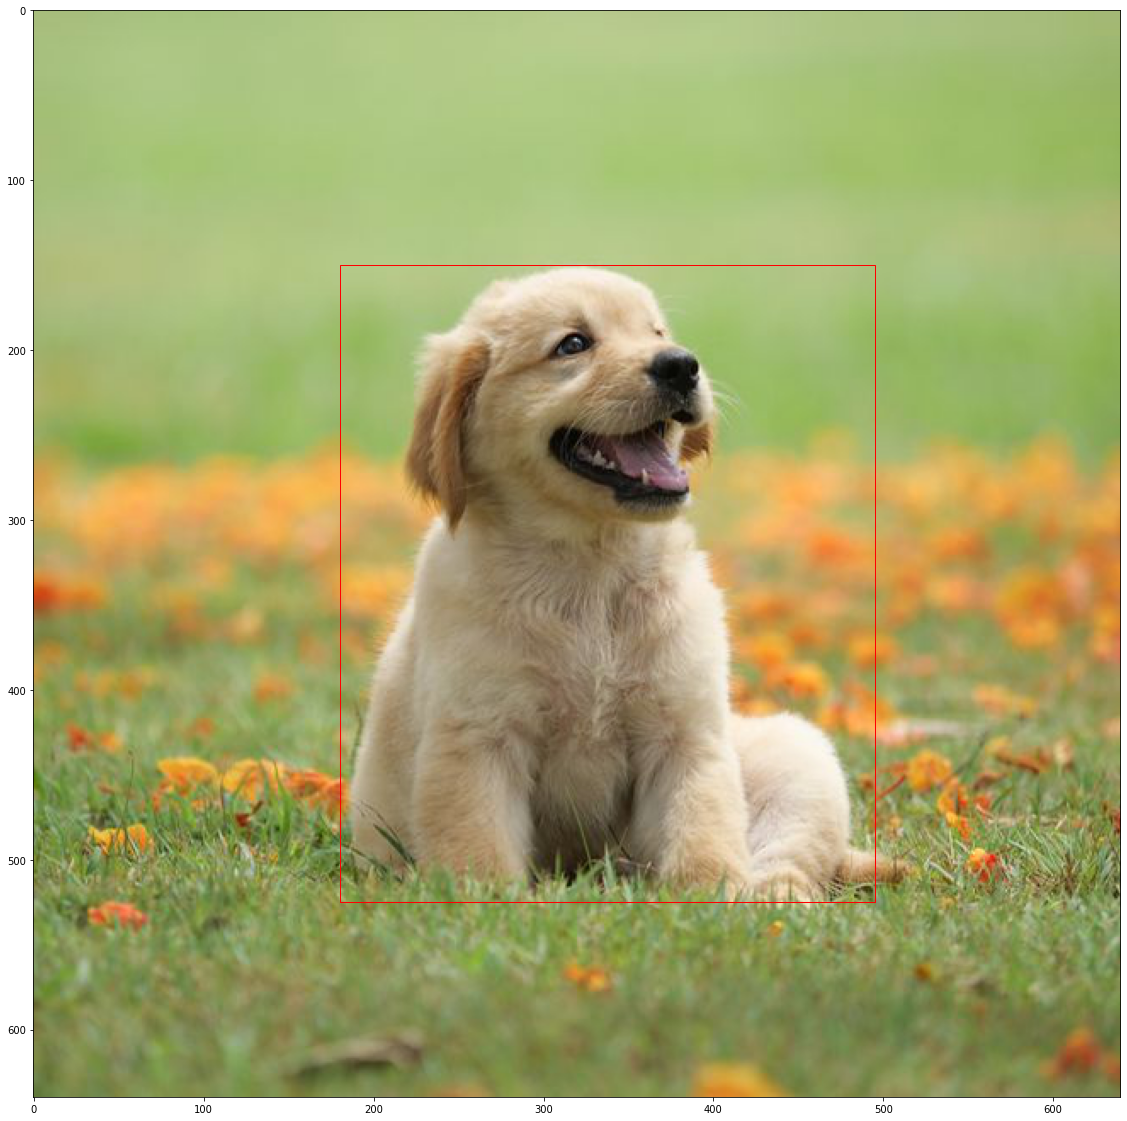

In [32]:
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(image_np)
patch = patches.Rectangle((180, 150), 315, 375, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [34]:
x1, y1, w, h = (180, 150, 315, 375)
x = int(x1 + (w/2))
y = int(y1 + (h/2))

In [37]:
labelled_data = {
    'classes' : {
        'Dog': 1
    },
    'annotations':[
        {'image_path': image_path,
         'bboxes': [[x, y, w, h]],
         'classes': ['Dog']}
    ]
}

In [38]:
with open('../models/data/sample/label.json', 'w') as fp:
    json.dump(labelled_data, fp)